# Mobile_Price_Classification

In [1]:
import numpy as np
import pandas as pd

# for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# for spliting data and hyperparameter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate,cross_val_score

# for pipeline and column_transformer
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline,make_pipeline

# for model
from sklearn.dummy import DummyClassifier,DummyRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
data = pd.read_excel('Mobile_price_classi.xlsx')
data.head(2)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2


# EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [4]:
# splitting the data
x,y = data.drop(columns=['price_range']),data['price_range']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=142)
# seperating features
categorical_features = [i for i in x_train.columns if len(x_train[i].value_counts()) == 2]
numerical_features = [i for i in x_train.columns if len(x_train[i].value_counts()) > 2]

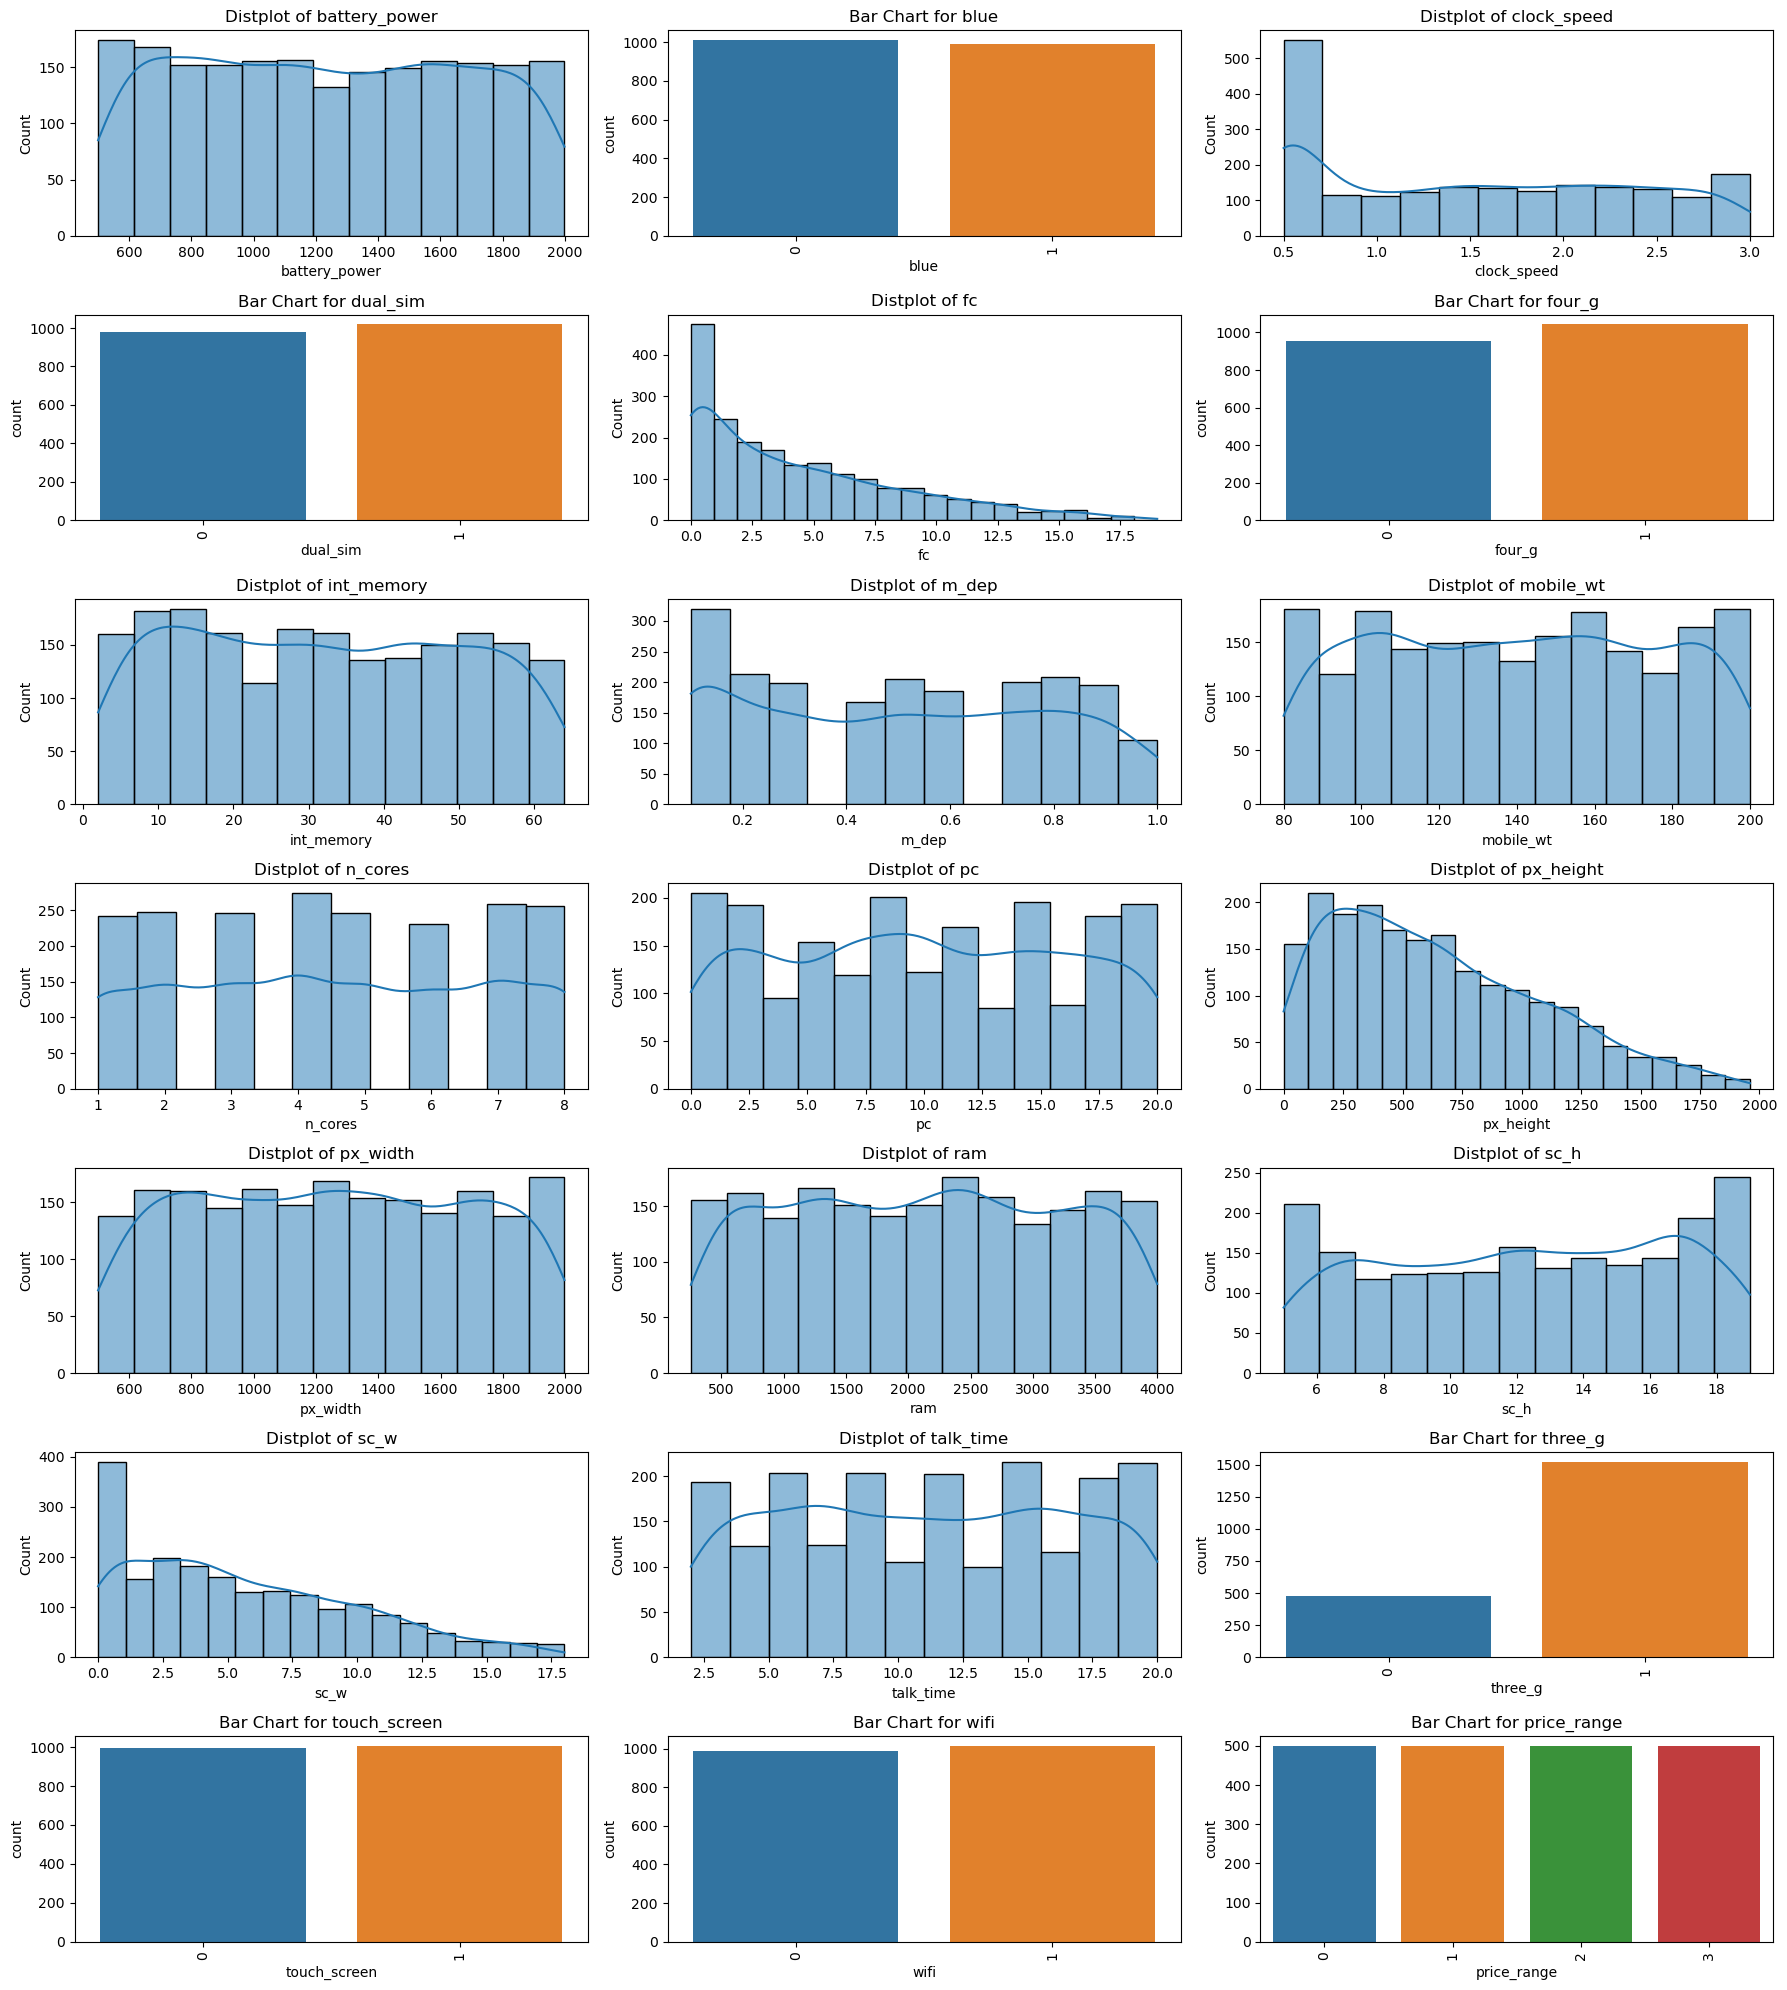

In [5]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(18, 20))

# Flatten the axes array for easy iteration
ax_array = axes.flatten()

for i, column in enumerate(data.columns):
    ax = ax_array[i]
    
    if column in numerical_features:
        sns.histplot(data[column], ax=ax, kde=True)
        ax.set_title(f'Distplot of {column}')
    else:
        sns.countplot(x=data[column], ax=ax)
        ax.set_title(f'Bar Chart for {column}')
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [6]:
# Removing constant-features :
from sklearn.feature_selection import VarianceThreshold
C_F_model = VarianceThreshold(threshold=0)
C_F_model.fit(x_train)
x_train.columns[C_F_model.get_support()]

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')

In [7]:
# preprocessing the data
scalar = make_pipeline(StandardScaler())
OHE = make_pipeline(OneHotEncoder(drop='if_binary'))
preprocessor = make_column_transformer((scalar,numerical_features),
                              (OHE,categorical_features))

In [8]:
# baseline of model
dummy = DummyClassifier()
pipe_dummy = make_pipeline(preprocessor,dummy)
pipe_dummy.fit(x_train,y_train)
pipe_dummy.score(x_train,y_train)

0.255625

# DecisionTreeClassifier

In [9]:
# getting train score using DecisionTreeClassifier 
DTC_model = DecisionTreeClassifier(random_state=123)
pipe_DTC = make_pipeline(DTC_model)
pipe_DTC.fit(x_train,y_train)
pipe_DTC.score(x_train,y_train)

1.0

In [10]:
# tuning hyperparameters
param_grid_DTC = {'decisiontreeclassifier__max_depth':np.arange(1,16)}
grid_search_DTC = GridSearchCV(pipe_DTC,param_grid_DTC,n_jobs=-1,cv=5,return_train_score=True)
grid_search_DTC.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=123))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])},
             return_train_score=True)

In [11]:
pd.DataFrame(grid_search_DTC.cv_results_).sort_values('rank_test_score').T

,11,12,13,14,10,6,9,8,7,5,4,3,1,2,0
mean_fit_time,0.083797,0.085128,0.071964,0.054544,0.046778,0.061399,0.052317,0.065615,0.074256,0.042996,0.037497,0.021641,0.027689,0.023822,0.024797
std_fit_time,0.0253,0.021916,0.011844,0.01558,0.000812,0.012719,0.009333,0.009853,0.010859,0.006052,0.007654,0.007948,0.01235,0.004788,0.005649
mean_score_time,0.006484,0.014203,0.012398,0.003592,0.0,0.006301,0.005124,0.006068,0.004776,0.003305,0.003125,0.012499,0.011444,0.005334,0.011197
std_score_time,0.007997,0.019265,0.004269,0.005412,0.0,0.007905,0.005705,0.005658,0.006423,0.00617,0.006249,0.00625,0.006091,0.00553,0.009199
param_decisiontreeclassifier__max_depth,12,13,14,15,11,7,10,9,8,6,5,4,2,3,1
params,{'decisiontreeclassifier__max_depth': 12},{'decisiontreeclassifier__max_depth': 13},{'decisiontreeclassifier__max_depth': 14},{'decisiontreeclassifier__max_depth': 15},{'decisiontreeclassifier__max_depth': 11},{'decisiontreeclassifier__max_depth': 7},{'decisiontreeclassifier__max_depth': 10},{'decisiontreeclassifier__max_depth': 9},{'decisiontreeclassifier__max_depth': 8},{'decisiontreeclassifier__max_depth': 6},{'decisiontreeclassifier__max_depth': 5},{'decisiontreeclassifier__max_depth': 4},{'decisiontreeclassifier__max_depth': 2},{'decisiontreeclassifier__max_depth': 3},{'decisiontreeclassifier__max_depth': 1}
split0_test_score,0.803125,0.803125,0.803125,0.803125,0.803125,0.840625,0.803125,0.796875,0.825,0.8125,0.803125,0.753125,0.74375,0.740625,0.50625
split1_test_score,0.859375,0.859375,0.859375,0.859375,0.853125,0.825,0.853125,0.846875,0.846875,0.83125,0.825,0.803125,0.759375,0.75625,0.509375
split2_test_score,0.859375,0.859375,0.859375,0.859375,0.859375,0.834375,0.85,0.85,0.81875,0.825,0.81875,0.759375,0.759375,0.75625,0.509375
split3_test_score,0.859375,0.859375,0.859375,0.859375,0.859375,0.853125,0.859375,0.85625,0.840625,0.84375,0.840625,0.7875,0.76875,0.753125,0.509375


In [12]:
DTC_best_params = 11

In [15]:
DTC_model = DecisionTreeClassifier(max_depth=DTC_best_params,random_state=123)
pipe_DTC = make_pipeline(preprocessor,DTC_model)
pipe_DTC.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=11, random_state=123))])

# score on DecisionTreeClassifier

In [18]:
DecisionTreeClassifier_score = pipe_DTC.score(x_test,y_test)
print(DecisionTreeClassifier_score)

0.81


# SVC

In [19]:
svc =SVC()
pipe_svc = make_pipeline(preprocessor,svc)
param_grid_svc = {'svc__C' : [0.0001,0.001,0.01,0.1,1,10,100,1000],
                 'svc__gamma' : [0.0001,0.001,0.01,0.1,1,10,100,1000]}
grid_search_svc = GridSearchCV(pipe_svc,param_grid=param_grid_svc,n_jobs = -1,cv = 5,return_train_score = True)
grid_search_svc.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['battery_power',
                                                                          'clock_speed',
                                                                          'fc',
                                                                          'int_memory',
                                                                          'm_dep',
                                                                          'mobile_wt',
                                                                          'n_cores',
                                                                          'pc',
                                                                          'px_height',
                                                                          'px_width',
                                                                          'ram',
                                                                          'sc_h',
                                                                          'sc_w',
                                                                          'talk_time']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['blue',
                                                                          'dual_sim',
                                                                          'four_g',
                                                                          'three_g',
                                                                          'touch_screen',
                                                                          'wifi'])])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                        1000]},
             return_train_score=True)

In [20]:
best_param_svc = grid_search_svc.best_params_
best_param_svc

{'svc__C': 1000, 'svc__gamma': 0.001}

In [21]:
svc = SVC(C= best_param_svc['svc__C'], gamma= best_param_svc['svc__gamma'])
model_svc = make_pipeline(preprocessor,svc)
model_svc.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('svc', SVC(C=1000, gamma=0.001))])

# Score on SVC

In [22]:
SVC_score = model_svc.score(x_test,y_test)
print(SVC_score)

0.9375


# LogisticRegression

In [23]:
import warnings 
warnings.filterwarnings('ignore')
lgr = LogisticRegression(random_state=123)
param_grid_lgr = {"logisticregression__C": [0.0001,0.001,0.01,0.1,1,10,100,1000],
                  "logisticregression__max_iter": [50,100,150,200,250,300,350]}
pipe_lgr = make_pipeline(preprocessor,lgr)
grid_search_lgr = GridSearchCV(pipe_lgr,param_grid=param_grid_lgr,n_jobs=-1,cv=5)
grid_search_lgr.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['battery_power',
                                                                          'clock_speed',
                                                                          'fc',
                                                                          'int_memory',
                                                                          'm_dep',
                                                                          'mobile_wt',
                                                                          'n_cores',
                                                                          'pc',
                                                                          'px_height',
                                                                          'px_width',
                                                                          'ram',
                                                                          'sc_h',
                                                                          'sc_w',
                                                                          'talk_time']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='if_binary'))]),
                                                                         ['blue',
                                                                          'dual_sim',
                                                                          'four_g',
                                                                          'three_g',
                                                                          'touch_screen',
                                                                          'wifi'])])),
                                       ('logisticregression',
                                        LogisticRegression(random_state=123))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1,
                                                   10, 100, 1000],
                         'logisticregression__max_iter': [50, 100, 150, 200,
                                                          250, 300, 350]})

In [24]:
best_param_lgr = grid_search_lgr.best_params_
best_param_lgr

{'logisticregression__C': 1000, 'logisticregression__max_iter': 50}

In [25]:
lgr = LogisticRegression(C=best_param_lgr['logisticregression__C'],max_iter=best_param_lgr['logisticregression__max_iter']
                         ,random_state=123)
model_lgr = make_pipeline(preprocessor,lgr)
model_lgr.fit(x_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['battery_power',
                                                   'clock_speed', 'fc',
                                                   'int_memory', 'm_dep',
                                                   'mobile_wt', 'n_cores', 'pc',
                                                   'px_height', 'px_width',
                                                   'ram', 'sc_h', 'sc_w',
                                                   'talk_time']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='if_binary'))]),
                                                  ['blue', 'dual_sim', 'four_g',
                                                   'three_g', 'touch_screen',
                                                   'wifi'])])),
                ('logisticregression',
                 LogisticRegression(C=1000, max_iter=50, random_state=123))])

# Score on LogisticRegression

In [26]:
LogisticRegression_score = model_lgr.score(x_test,y_test)
print(LogisticRegression_score)

0.9625


# RandomForestClassifier

In [27]:
random_forest_classifier = RandomForestClassifier(random_state=123)
param_grid_rfc = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': list(np.arange(1, 16))
}

grid_search_rfc = GridSearchCV(random_forest_classifier, param_grid=param_grid_rfc, n_jobs=-1, cv=5)
grid_search_rfc.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15],
                         'n_estimators': [50, 100, 150, 200, 250, 300]})

In [28]:
best_param_rfc = grid_search_rfc.best_params_
best_param_rfc

{'max_depth': 13, 'n_estimators': 200}

In [29]:
model_rfc=RandomForestClassifier(n_estimators=best_param_rfc['n_estimators'],max_depth=best_param_rfc['max_depth']
                             ,random_state=123,n_jobs=-1)
model_rfc.fit(x_train,y_train)

RandomForestClassifier(max_depth=13, n_estimators=200, n_jobs=-1,
                       random_state=123)

# Score on RandomForestClassifier

In [30]:
RandomForestClassifier_score = model_rfc.score(x_test,y_test)
print(RandomForestClassifier_score)

0.87

# XGBClassifier

In [31]:
xgbc = XGBClassifier()
xgbc.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# score on XGBClassifier

In [32]:
XGBClassifier = xgbc.score(x_test,y_test)
print(XGBClassifier)

0.925


### got the best score of 96.25 percent on LogisticRegression, therefore our best model is LogisticRegression